In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## Some thoughts on greedy scheduling

We have speculated that our scheduling problem without too many constraints is easy—that is, polynomial-time heuristic methods can produce a $1+\epsilon$-optimal approximation of the best scheduling with respect to some objective function. Here we show that an extremely simple greedy algorithm with nearly equivalent performance to our existing IP/LP formulations: it performs almost as well as the linear programming formulations for day-to-day balance (at least for some distributions of personal schedules) and maintains the best possible testing intervals for all people.

### Randomized greedy scheduling
**Method**: For each personal schedule, we determine the best possible testing interval (or more generally, the best possible reward) for that schedule. We randomly sample testing schedules and accept when a compatible testing schedule is found with the best possible testing interval.

If the personal schedules and testing schedules are approximately uniformly distributed across days, then the resulting assignment should be close to uniformly distributed as well. (If necessary, it seems that we can get some exact results about this by considering the sums of binomial distributions.)

In [2]:
n_days = 7
test_interval = 3.5
n_tests = n_days / test_interval
buffer = .05

In [3]:
person_schedules = ['{:07b}'.format(i) for i in range(2 ** n_days)
                    if '{:b}'.format(i).count('1') >= n_tests]
test_schedules = ['{:07b}'.format(i) for i in range(2 ** n_days)
                    if '{:b}'.format(i).count('1') == n_tests]

We reuse the parameters and the setup of the bipartite matching notebook here. However, note that it is not strictly necessary to enumerate either the personal schedules or the test schedules: while the number of possible personal schedules is exponential in the number of days, it is upper-bounded by the number of people at a university (and in practice, many full-time residential undergraduates will have identical schedules that include most of the week). Furthermore, testing schedules can be sampled via rejection sampling or some other method without the full enumeration. The number of testing schedules is also upper-bounded by the number of people.

In [4]:
test_costs = np.zeros(len(test_schedules))
test_days = np.zeros((n_days, len(test_schedules)))
test_schedule_intervals = []
for idx, sched in enumerate(test_schedules):
    interval = sched[sched.index('1') + 1:].index('1') + 1
    test_schedule_intervals.append(interval)
    test_days[sched.index('1'), idx] = 1
    test_days[sched.index('1') + interval, idx] = 1
    test_costs[idx] = (interval - test_interval)**2

In [5]:
def compatible(person_schedule, test_schedule):
    return not any(t == '1' and p == '0'
                   for t, p in zip(test_schedule, person_schedule))

In [6]:
np.random.seed(1)
demand_per_schedule = np.random.randint(0, 100, len(person_schedules))
exp_supply_per_day = demand_per_schedule.sum() / test_interval

In [7]:
day_bins = np.arange(1, n_days + 1)
availability = np.zeros(n_days)
for weight, sched in zip(demand_per_schedule, person_schedules):
    for day_idx, avail in enumerate(sched):
        if avail == '1':
            availability[day_idx] += weight

Our current method of sampling personal schedules produces an approximately uniform availabililty-day distribution.

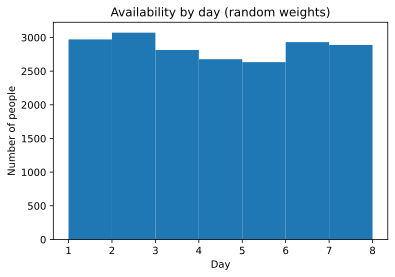

In [8]:
plt.hist(day_bins,
         bins=n_days,
         weights=availability,
         range=(1, n_days + 1))
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.title('Availability by day (random weights)')
plt.show()

In [9]:
def random_greedy(weights):
    sol = np.zeros((len(person_schedules), len(test_schedules)))
    for p_idx, p_sched in enumerate(person_schedules):
        # Determine the lowest possible testing cost.
        best_cost = n_days ** 2
        for outer_idx, outer_c in enumerate(p_sched):
            for inner_idx, inner_c in enumerate(p_sched[outer_idx + 1:]):
                if inner_c == '1' and outer_c == '1':
                    best_cost = min(best_cost, (inner_idx + 1 - test_interval)**2)
                    
        # Assign each person with the current schedule individually.
        for _ in range(weights[p_idx]):
            # Sample testing schedules until an optimal compatible testing schedule is found.
            test_idx = 0
            cost = n_days ** 2
            while cost > best_cost:
                test_idx = np.random.randint(0, len(test_schedules))
                if compatible(p_sched, test_schedules[test_idx]):
                    cost = test_costs[test_idx]
            sol[p_idx, test_idx] += 1
    return sol

In [20]:
max_deviations = []
demand_per_schedule = np.random.randint(0, 100, len(person_schedules))
exp_supply_per_day = demand_per_schedule.sum() / test_interval

for _ in range(100):
    sol = random_greedy(demand_per_schedule)
    daily_demands = test_days @ sol.sum(axis=0)
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                    exp_supply_per_day - daily_demands.min()) / exp_supply_per_day
    max_deviations.append(max_deviation)

For the parameters used, we can frequently attain a ~10% maximum deviation from the expected number of daily tests without any tweaking of the solution.

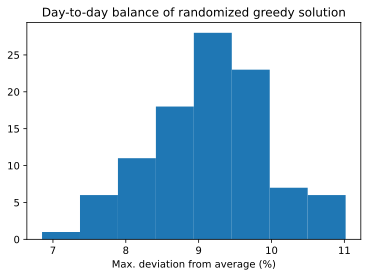

In [21]:
plt.title('Day-to-day balance of randomized greedy solution')
plt.hist(100 * np.array(max_deviations), bins=8)
plt.xlabel('Max. deviation from average (%)')
plt.show()

#### Last solution
Here are some more detailed statistics for one run.

In [12]:
print('Daily demand (min):', daily_demands.min())
print('Daily demand (max):', daily_demands.max())
print('All daily demands:', daily_demands)
print('Maximum deviation: {:.1f}%'.format(max_deviation * 100))

Daily demand (min): 1628.0
Daily demand (max): 1906.0
All daily demands: [1665. 1797. 1906. 1698. 1834. 1888. 1628.]
Maximum deviation: 7.5%


In [13]:
sol_interval_counts = defaultdict(int)
for idx, count in enumerate(sol.sum(axis=0)):
    sol_interval_counts[test_schedule_intervals[idx]] += count

These counts may change across solutions, but for a symmetric testing window/interval pairing (e.g. 7 days, Q3.5 testing), pairwise counts should not change. For instance, the sum of the number of assignments with 3-day spacing and 4-day spacing should not change, and the sum of the number of assignments with 1-day and 6-day spacing should not change. This is due to the objective function's symmetric penalty. 

In [14]:
print('--- Tests by spacing ---')
for interval, count in sol_interval_counts.items():
    print('{:d} days: {:d}'.format(interval, int(count)))

--- Tests by spacing ---
1 days: 293
2 days: 590
3 days: 2861
4 days: 2265
5 days: 185
6 days: 14


## Tuning solutions

In [15]:
raw_sol = random_greedy(demand_per_schedule)

In [82]:
def balance_hill_climbing(raw_sol, max_step_size=5, n_steps=2000):
    sol = raw_sol.copy()
    daily_demands = test_days @ sol.sum(axis=0)
    deviation_squared = np.sum((daily_demands - exp_supply_per_day)**2)
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                        exp_supply_per_day - daily_demands.min()) / exp_supply_per_day
    ds_over_time = [deviation_squared]
    d_max_over_time = [max_deviation]
        
    # At each step, try to move a random group of people from the schedule they are
    # at (for a raw solution, this schedule is guaranteed to be optimally
    # spaced) to a schedule with equal cost. Check if the objective improves.
    for _ in range(n_steps):
        populated_row, populated_col = np.where(sol > 0)
        rand_idx = np.random.randint(len(populated_row))
        rand_person_schedule = populated_row[rand_idx]
        rand_test_schedule = populated_col[rand_idx]
        cost = test_costs[rand_test_schedule]
        choices = [idx for idx in range(len(test_schedules))
                   if compatible(person_schedules[rand_person_schedule], 
                                 test_schedules[idx]) and test_costs[idx] == cost]
        if len(choices) > 1:
            new_test_schedule = np.random.choice(choices)
            person_delta = min(sol[rand_person_schedule, rand_test_schedule],
                                max_step_size)

            new_sol = sol.copy()
            new_sol[rand_person_schedule, rand_test_schedule] -= person_delta
            new_sol[rand_person_schedule, new_test_schedule] += person_delta
            new_daily_demands = test_days @ new_sol.sum(axis=0)
            new_deviation_squared = np.sum((new_daily_demands - exp_supply_per_day)**2)
            if new_deviation_squared < deviation_squared:
                sol = new_sol
                deviation_squared = new_deviation_squared
                daily_demands = new_daily_demands
                max_deviation = (max(daily_demands.max() - exp_supply_per_day,
                                    exp_supply_per_day - daily_demands.min()) /
                                 exp_supply_per_day)
        ds_over_time.append(deviation_squared)
        d_max_over_time.append(max_deviation)
    return ds_over_time, d_max_over_time

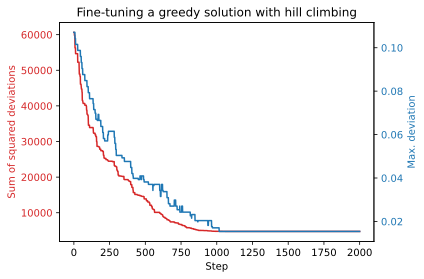

In [83]:
ds, d_max = balance_hill_climbing(raw_sol)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = 'tab:red'
ax1.set_xlabel('Step')
ax1.set_ylabel('Sum of squared deviations', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(ds, color=color)

color = 'tab:blue'
ax2.set_ylabel('Max. deviation', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(d_max, color=color)

ax1.set_title('Fine-tuning a greedy solution with hill climbing')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('hill_climbing.png', dpi=300, bbox_inches='tight')

In [84]:
d_max[-1]

0.015399269725353265

In [85]:
d_max[0]

0.10708048896650266

In [ ]:
%timeit balance_hill_climbing(raw_sol)